In [1]:
''' compute & plot taux, tauy, taux_correct, tauy_correct, raw & NI-bandpassed velocity, AND wind power input & integral of wind power input
    C12 buoy's met data: Measurements are collected twice per hour (timestamp at :05 and :35 minutes past the hour). 
        Measurements consist of 10 minute averages of 1 second samples, with the averages centered on the hour and half hour.
    C12 buoy's current data: Measurements are collected on the hour (timestamp at :57 for sample at the top of the next hour) and 
        consist of 6 minute averages of 1 second samples, with the averages centered on the hour.
    Saildrone wind data: 1-min average of 20Hz data.
    Saildrone current data: 5-min average of 1Hz data. 
    ---
    This version computes hourly wind power from averaged wind and velocity. C12 buoy is 
        a 2 x 10-min /6-min averageds of 1Hz wind / current velocity data for each hour.
    This version includes total wind power, not just the wind power to near-inertial motion
'''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import sys
import re
from numpy.linalg import norm
from scipy.interpolate import interp1d
from metpy.calc import wind_components, density, mixing_ratio_from_relative_humidity, wind_direction
from metpy.units import units
from oceans.ocfis import spdir2uv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from windstr import ra_windstr_nc
from convert_dir import vector_dir_to_from
from mystats import bandpass
from values_to_colors import values_to_rgba

In [2]:
### Data info
### buoy data info
year = '2023'
buoy_id = '42022'
path_met_buoy = '/Users/chi/Documents/Data/NDBC/'
fn_met = 'met_ndbc'+buoy_id+'_y'+year+'.txt'
path_cur_buoy = '/Users/chi/Documents/Data/NDBC/'
fn_cur = 'current_ndbc'+buoy_id+'_y'+year+'.txt'
lat_buoy = 27.505
### SD data info
platf_num = '1042'
path_met_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
path_cur_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
### SD-1042 merged nc file info
# tlim_plot = [datetime.datetime(int(year),10,19,12), datetime.datetime(int(year),11,15,23)] ### 2023 SD1042
tlim_plot = [datetime.datetime(int(year),10,19,12), datetime.datetime(int(year),10,30,12)] ### 2023 SD1042
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]

In [3]:
### LOAD MET DATA ###
dt_adjust_met = datetime.timedelta(minutes=-5)
dt_adjust_cur = datetime.timedelta(minutes=3)
### read met data
arrayMet = np.genfromtxt(path_met_buoy+fn_met,skip_header=2)
arrayMet[arrayMet== 999] = np.nan
### convert to datetime
dtime_met_buoy = []
for i in range( arrayMet.shape[0] ):
    dtime_met_buoy.append( datetime.datetime(int(arrayMet[i,0]),int(arrayMet[i,1]),int(arrayMet[i,2]),int(arrayMet[i,3]),int(arrayMet[i,4]))+dt_adjust_met )
dtime_met_buoy = np.array( dtime_met_buoy )
print('buoy met data time:',dtime_met_buoy[0:2],'...')
### convert to u & v wind components
uwnd_buoy, vwnd_buoy = wind_components(arrayMet[:,6]*units('m/s'),arrayMet[:,5]*units.deg)
uwnd_buoy = np.array(uwnd_buoy)
vwnd_buoy = np.array(vwnd_buoy)

### load airsea data
ds_met_SD = nc.Dataset(path_met_SD+'airsea-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_met_SD.variables['time'][:]
# print(ds_met_SD.variables['time'].units)
dtime_met_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uwnd_SD = ds_met_SD.variables['UWND_MEAN'][:]
vwnd_SD = ds_met_SD.variables['VWND_MEAN'][:]
print('SD met data time:',dtime_met_SD[0:2],'...')

buoy met data time: [datetime.datetime(2023, 1, 1, 0, 0) datetime.datetime(2023, 1, 1, 0, 30)] ...
SD met data time: [datetime.datetime(2023, 10, 17, 10, 0)
 datetime.datetime(2023, 10, 17, 10, 1)] ...


In [4]:
### LOAD BUOY CURRENT VELOCITY DATA ###
### Read buoy current data
nline_header = 2 ### need to check lines of headers manually
with open(path_cur_buoy+fn_cur, 'r') as f:
    nrow = len(f.readlines())
    print('Total Number of lines in the current data file:', nrow)
### get the headers & number of items in the header
count = 0
print('The caveat is that the file does not have exact same number of items in the header as in the data...')
with open(path_cur_buoy+fn_cur, 'r') as f:
    for line in f:
        if count == nline_header:
            line_1 = re.sub(r"\s+",',',line) ### replace space(s) with ','
            if line_1[-1] == ',':
                line_1 = line_1[:-1]
            break
        count = count + 1
### read through the file
line_1_list = line_1.split(',')
ncol = len(line_1_list) # number of items in the first line of data
arrayCur = np.nan*np.ones( (nrow-nline_header,ncol) ) ### record values only
count = 0
with open(path_cur_buoy+fn_cur) as f:
    for line in f:
        count = count + 1
        line_1 = re.sub(r"\s+",',',line)
        if line_1[-1] == ',':
                line_1 = line_1[:-1]
        # print(line_1)
        if count > nline_header:
            temp = line_1.split(',')
            temp = [float(item) for item in temp]
            nitem = len(temp)
            arrayCur[count-nline_header-1,0:nitem] = np.array(temp)
        
print('Shape of arrayCur:',arrayCur.shape)
arrayCur[arrayCur == 999] = np.nan

### convert to datetime
dtime_cur_buoy = []
for i in range( arrayCur.shape[0] ):
    dtime_cur_buoy.append( datetime.datetime(int(arrayCur[i,0]),int(arrayCur[i,1]),int(arrayCur[i,2]),int(arrayCur[i,3]),int(arrayCur[i,4]))+dt_adjust_cur )
dtime_cur_buoy = np.array( dtime_cur_buoy )
print('buoy current data time:',dtime_cur_buoy[0:2],'...')
### depths of current
depths_cur_buoy = arrayCur[0,5:-1:3]
print('Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters:', depths_cur_buoy)

### compute u & v current velocity from speed (cm/s) and direction (flowing toward) from the current data
uCur_buoy = np.nan*np.ones( (arrayCur.shape[0],len(depths_cur_buoy)) )
vCur_buoy = uCur_buoy.copy()
i0dep = 5
i0dir = 6
i0spd = 7
for i in range( uCur_buoy.shape[0] ): ### time dimension
    for z in range( len(depths_cur_buoy) ): ### depth dimension
        spd_item = arrayCur[i,i0spd+z*3]
        dir_to_item = arrayCur[i,i0dir+z*3] # direction flowing toward
        dir_from_item = (dir_to_item+180)%360
        # print(spd_item, dir_from_item, dir_to_item)
        uCur_buoy[i,z], vCur_buoy[i,z] = spdir2uv( spd_item,dir_to_item,deg=True )

Total Number of lines in the current data file: 6977
The caveat is that the file does not have exact same number of items in the header as in the data...
Shape of arrayCur: (6975, 125)
buoy current data time: [datetime.datetime(2023, 1, 1, 1, 0) datetime.datetime(2023, 1, 1, 2, 0)] ...
Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters: [42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25.
 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.
  6.  5.  4.  3.]


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_93246/159625598.py:59: RuntimeWarning: invalid value encountered in double_scalars
  dir_from_item = (dir_to_item+180)%360


Depths of SD: [  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]


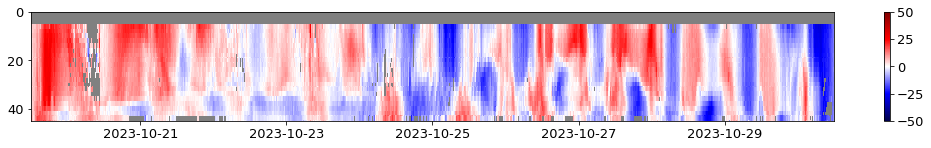

In [5]:
### LOAD SD CURRENT VELOCITY DATA ###
ds_cur_SD = nc.Dataset(path_cur_SD+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_cur_SD.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uCur_SD = ds_cur_SD.variables['vel_east'][:]*100 # cm/s
vCur_SD = ds_cur_SD.variables['vel_north'][:]*100
depths_cur_SD = ds_cur_SD.variables['depth'][:] # the shallowest depth should be ~6m. 
depths_cur_SD = depths_cur_SD+1.8
data_flag = ds_cur_SD.variables['data_flag'][:]
print('Depths of SD:',depths_cur_SD)
### apply nan to flagged values
uCur_SD[data_flag > 0] = np.nan
vCur_SD[data_flag > 0] = np.nan
### plot
plt.clf()
plt.gcf().set_size_inches(18, 2)
plt.rcParams.update({'font.size': 13})
plt.pcolor(dtime_cur_SD, depths_cur_SD, uCur_SD.transpose(),cmap='seismic',vmin=-50,vmax=50)
plt.ylim([0,45])
plt.gca().invert_yaxis()
plt.xlim(tlim_plot)
plt.gca().set_facecolor('gray')
plt.colorbar()

In [ ]:
### average wind to buoy currents' hourly temporal grid
dsec_hr = datetime.timedelta(hours=1).total_seconds()
dsec_5min = datetime.timedelta(minutes=5).total_seconds()
print(dsec_hr, dsec_5min, type(dsec_hr))
nt_hr = int( (tlim_plot[1]-tlim_plot[0]).total_seconds()/dsec_hr )
dtime_hr_grid = np.array([tlim_plot[0]+datetime.timedelta(seconds=i*dsec_hr) for i in range(nt_hr)])
nt_5min = int( (tlim_plot[1]-tlim_plot[0]).total_seconds()/dsec_5min )
dtime_5min_grid = np.array([tlim_plot[0]+datetime.timedelta(seconds=i*dsec_5min) for i in range(nt_5min)])
print('buoy current (hrly) temporal grid:',dtime_hr_grid[0:2],dtime_hr_grid[-1])
### average wind & current to hourly temporal grid
uwnd_buoy_hr = np.nan*np.ones( dtime_hr_grid.shape )
vwnd_buoy_hr = uwnd_buoy_hr.copy()
uwnd_SD_hr = uwnd_buoy_hr.copy()
vwnd_SD_hr = uwnd_SD_hr.copy()
ucur_SD_hr = np.nan*np.ones( (len(dtime_hr_grid),len(depths_cur_SD)) )
vcur_SD_hr = ucur_SD_hr.copy()
for i in range( len(dtime_hr_grid) ):
    ### buoy wind
    it_met_buoy = np.where( (dtime_met_buoy+datetime.timedelta(hours=0.5) >= dtime_hr_grid[i]) &\
                            (dtime_met_buoy-datetime.timedelta(hours=0.5) < dtime_hr_grid[i]) )[0]
    uwnd_buoy_hr[i] = np.nanmean( uwnd_buoy[it_met_buoy])
    vwnd_buoy_hr[i] = np.nanmean( vwnd_buoy[it_met_buoy])
    ### SD wind
    it_met_SD = np.where( (dtime_met_SD+datetime.timedelta(hours=0.5) >= dtime_hr_grid[i]) &\
                          (dtime_met_SD-datetime.timedelta(hours=0.5) < dtime_hr_grid[i]) )[0]
    uwnd_SD_hr[i] = np.nanmean( uwnd_SD[it_met_SD])
    vwnd_SD_hr[i] = np.nanmean( vwnd_SD[it_met_SD])
    # SD current
    it_cur_SD = np.where( (dtime_cur_SD+datetime.timedelta(hours=0.5) >= dtime_hr_grid[i]) &\
                          (dtime_cur_SD-datetime.timedelta(hours=0.5) < dtime_hr_grid[i]) )[0]
    if len(it_cur_SD) > 0:
        for z in range( len(depths_cur_SD) ):
            ucur_SD_hr[i,z] = np.nanmean( uCur_SD[it_cur_SD,z])
            vcur_SD_hr[i,z] = np.nanmean( vCur_SD[it_cur_SD,z])
### slice buoy current to tlim_plot
it_cur_buoy = np.where( (dtime_cur_buoy>= tlim_plot[0]) & (dtime_cur_buoy< tlim_plot[1]))[0]
print('sliced current shape:',it_cur_buoy.shape, 'dtime_hr_grid shape:',dtime_hr_grid.shape)
ucur_buoy_hr = uCur_buoy[it_cur_buoy,:]
vcur_buoy_hr = vCur_buoy[it_cur_buoy,:]

### compute the 5-min averaged SD wind / current
uwnd_SD_5min = np.nan*np.ones( dtime_5min_grid.shape )
vwnd_SD_5min = uwnd_SD_5min.copy()
ucur_SD_5min = np.nan*np.ones( (len(dtime_5min_grid),len(depths_cur_SD)) )
vcur_SD_5min = ucur_SD_5min.copy()
for i in range( len(dtime_5min_grid) ):
    ### SD wind
    it_met_SD = np.where( (dtime_met_SD+datetime.timedelta(minutes=2.5) >= dtime_5min_grid[i]) &\
                          (dtime_met_SD-datetime.timedelta(minutes=2.5) < dtime_5min_grid[i]) )[0]
    uwnd_SD_5min[i] = np.nanmean( uwnd_SD[it_met_SD])
    vwnd_SD_5min[i] = np.nanmean( vwnd_SD[it_met_SD])
    ### SD current
    it_cur_SD = np.where( (dtime_cur_SD+datetime.timedelta(minutes=2.5) >= dtime_5min_grid[i]) &\
                          (dtime_cur_SD-datetime.timedelta(minutes=2.5) < dtime_5min_grid[i]) )[0]
    if len(it_cur_SD) > 0:
        for z in range( len(depths_cur_SD) ):
            ucur_SD_5min[i,z] = np.nanmean( uCur_SD[it_cur_SD,z])
            vcur_SD_5min[i,z] = np.nanmean( vCur_SD[it_cur_SD,z])


3600.0 300.0 <class 'float'>
buoy current (hrly) temporal grid: [datetime.datetime(2023, 10, 19, 12, 0)
 datetime.datetime(2023, 10, 19, 13, 0)] 2023-10-30 11:00:00


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_93246/45174439.py:33: RuntimeWarning: Mean of empty slice
  ucur_SD_hr[i,z] = np.nanmean( uCur_SD[it_cur_SD,z])
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_93246/45174439.py:34: RuntimeWarning: Mean of empty slice
  vcur_SD_hr[i,z] = np.nanmean( vCur_SD[it_cur_SD,z])


sliced current shape: (264,) dtime_hr_grid shape: (264,)


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_93246/45174439.py:57: RuntimeWarning: Mean of empty slice
  ucur_SD_5min[i,z] = np.nanmean( uCur_SD[it_cur_SD,z])
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_93246/45174439.py:58: RuntimeWarning: Mean of empty slice
  vcur_SD_5min[i,z] = np.nanmean( vCur_SD[it_cur_SD,z])
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_93246/45174439.py:50: RuntimeWarning: Mean of empty slice
  uwnd_SD_5min[i] = np.nanmean( uwnd_SD[it_met_SD])
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_93246/45174439.py:51: RuntimeWarning: Mean of empty slice
  vwnd_SD_5min[i] = np.nanmean( vwnd_SD[it_met_SD])


In [17]:
### compute the wind stress
iz_buoy = np.argmin( np.abs(depths_cur_buoy-6) ) ### depth indice to plot
iz_SD = np.argmin( np.abs(depths_cur_SD-6) )
roh = 1.2
### corrected wind stress by current velocity
taux_c_buoy_hr, tauy_c_buoy_hr = ra_windstr_nc(uwnd_buoy_hr-0.01*ucur_buoy_hr[:,iz_buoy], vwnd_buoy_hr-0.01*vcur_buoy_hr[:,iz_buoy],roh)
taux_c_SD_hr, tauy_c_SD_hr = ra_windstr_nc(uwnd_SD_hr-0.01*ucur_SD_hr[:,iz_SD], vwnd_SD_hr-0.01*vcur_SD_hr[:,iz_SD],roh)
taux_c_SD_5min, tauy_c_SD_5min = ra_windstr_nc(uwnd_SD_5min-0.01*ucur_SD_5min[:,iz_SD], vwnd_SD_5min-0.01*vcur_SD_5min[:,iz_SD],roh)

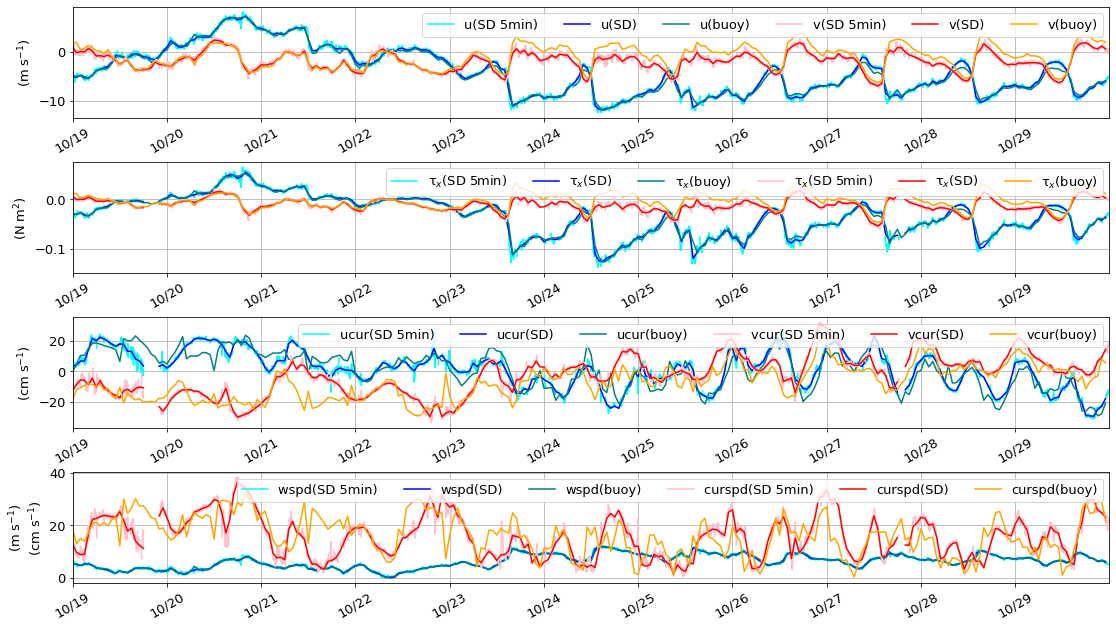

In [36]:
### plot the linearly interpolated wind and current (on current's grids)
wspd_buoy_hr = np.sqrt( np.square(uwnd_buoy_hr) + np.square(vwnd_buoy_hr) )
curspd_buoy_hr = np.sqrt( np.square(ucur_buoy_hr) + np.square(vcur_buoy_hr) )
wspd_SD_hr = np.sqrt( np.square(uwnd_SD_hr) + np.square(vwnd_SD_hr) )
curspd_SD_hr = np.sqrt( np.square(ucur_SD_hr) + np.square(vcur_SD_hr) )
wspd_SD_5min = np.sqrt( np.square(uwnd_SD_5min) + np.square(vwnd_SD_5min) )
curspd_SD_5min = np.sqrt( np.square(ucur_SD_5min) + np.square(vcur_SD_5min) )
###
platforms = ['SD','buoy']
var_str = [['uwnd','vwnd'],['taux_c','tauy_c'],['ucur','vcur'],['wspd','curspd']]
var_str_label = [['u','v'],['\u03C4'+'$_x$','\u03C4'+'$_x$'],['ucur','vcur'],['wspd','curspd']]
var_unit = ['(m s$^{-1}$)','(N m$^2$)','(cm s$^{-1}$)',['(m s$^{-1}$)','(cm s$^{-1}$)']]
col_in1 = [['blue','teal','cyan'],['red','orange','pink']]
### 
nrow = len(var_str)
plt.clf()
plt.gcf().set_size_inches(18, 10)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    for v in range( len(var_str[i]) ):
        exec_str1 = 'var1 = '+var_str[i][v]+'_'+platforms[0]+'_hr'
        exec_str2 = 'var2 = '+var_str[i][v]+'_'+platforms[1]+'_hr'
        exec_str3 = 'var3 = '+var_str[i][v]+'_'+platforms[0]+'_5min'
        if ('cur' in var_str[i][v]):# & ('spd' not in var_str[i][v]):
            exec_str1 = exec_str1+'[:,iz_'+platforms[0]+']'
            exec_str2 = exec_str2+'[:,iz_'+platforms[1]+']'
            exec_str3 = exec_str3+'[:,iz_'+platforms[0]+']'
        exec(exec_str1)
        exec(exec_str2)
        exec(exec_str3)
        plt.plot(dtime_5min_grid, var3,color=col_in1[v][2],label=var_str_label[i][v]+'('+platforms[0]+' 5min)')
        plt.plot(dtime_hr_grid, var1,color=col_in1[v][0],label=var_str_label[i][v]+'('+platforms[0]+')')
        plt.plot(dtime_hr_grid, var2,color=col_in1[v][1],label=var_str_label[i][v]+'('+platforms[1]+')')
    plt.legend(ncol=6,loc='best')
    if isinstance(var_unit[i],str):
        plt.ylabel(var_unit[i])
    else:
        plt.ylabel('\n'.join(var_unit[i]))
    ### figure settings
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()
    
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.4)
### save to figure
plt.savefig('timeseries_wind_tau_c_cur(QC)_spd_'+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(depths_cur_buoy[iz_buoy])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_mn-hr-5min-grid.png',dpi=400,bbox_inches='tight')

In [57]:
### band pass current velocity to NI band
f_buoy = 2*(2*np.pi/86400)*np.sin(lat_buoy/180*np.pi) # 1/s
n_f = np.array([0.8,1.3]) #[0.8,1.2] [0.75,1.25]
f_bp = f_buoy*n_f
ucur_buoy_hr_bp = np.nan*np.ones( ucur_buoy_hr.shape )
vcur_buoy_hr_bp = ucur_buoy_hr_bp.copy()
ucur_SD_hr_bp = ucur_buoy_hr_bp.copy()
vcur_SD_hr_bp = ucur_buoy_hr_bp.copy()
ucur_SD_5min_bp = np.nan*np.ones( ucur_SD_5min.shape )
vcur_SD_5min_bp = ucur_SD_5min_bp.copy()
### timestamp
timestamp_hr_grid = np.array([dtime.timestamp() for dtime in dtime_hr_grid])
timestamp_5min_grid = np.array([dtime.timestamp() for dtime in dtime_5min_grid])

### buoy
bp_sec = 2*np.pi/f_bp
for z in range( ucur_buoy_hr_bp.shape[1] ):
    isOK = ~np.isnan(ucur_buoy_hr[:,z])
    if np.sum( isOK )> 10:
        temp = np.interp( timestamp_hr_grid,timestamp_hr_grid[isOK],ucur_buoy_hr[isOK,z],left=np.nan,right=np.nan)
        ucur_buoy_hr_bp[:,z], _,_,_,_  = bandpass(temp,dsec_hr,bp_sec[0],bp_sec[1],2)
        temp = np.interp( timestamp_hr_grid,timestamp_hr_grid[isOK],vcur_buoy_hr[isOK,z],left=np.nan,right=np.nan)
        vcur_buoy_hr_bp[:,z], _,_,_,_  = bandpass(temp,dsec_hr,bp_sec[0],bp_sec[1],2)
### SD
for z in range( ucur_SD_hr_bp.shape[1] ):
    isOK = ~np.isnan(ucur_SD_hr[:,z])
    if np.sum( isOK )> 10:
        temp = np.interp( timestamp_hr_grid,timestamp_hr_grid[isOK],ucur_SD_hr[isOK,z])
        ucur_SD_hr_bp[:,z], _,_,_,_  = bandpass(temp,dsec_hr,bp_sec[0],bp_sec[1],2)
        temp = np.interp( timestamp_hr_grid,timestamp_hr_grid[isOK],vcur_SD_hr[isOK,z])
        vcur_SD_hr_bp[:,z], _,_,_,_  = bandpass(temp,dsec_hr,bp_sec[0],bp_sec[1],2)
    isOK = ~np.isnan(ucur_SD_5min[:,z])
    if z == 0:
        print(np.sum(isOK), timestamp_5min_grid.shape)
    if np.sum( isOK )> 10:
        temp = np.interp( timestamp_5min_grid,timestamp_5min_grid[isOK],ucur_SD_5min[isOK,z])
        ucur_SD_5min_bp[:,z], _,_,_,_  = bandpass(temp,dsec_5min,bp_sec[0],bp_sec[1],2)
        temp = np.interp( timestamp_5min_grid,timestamp_5min_grid[isOK],vcur_SD_5min[isOK,z])
        vcur_SD_5min_bp[:,z], _,_,_,_  = bandpass(temp,dsec_5min,bp_sec[0],bp_sec[1],2)


2817 (3168,)


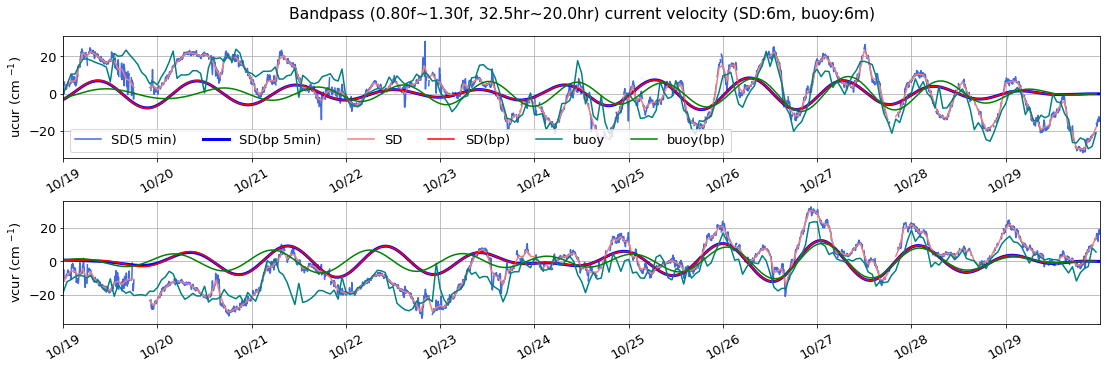

In [67]:
col_in1 = [['royalblue','blue'],['lightcoral','red'],['teal','green']]
### plot current
nrow = 2
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
### u
plt.subplot(nrow,1,1)
plt.plot(dtime_5min_grid, ucur_SD_5min[:,iz_SD],label='SD(5 min)',color=col_in1[0][0])
plt.plot(dtime_5min_grid, ucur_SD_5min_bp[:,iz_SD],lw=3,label='SD(bp 5min)',color=col_in1[0][1])
plt.plot(dtime_hr_grid, ucur_SD_hr[:,iz_SD],label='SD',color=col_in1[1][0])
plt.plot(dtime_hr_grid, ucur_SD_hr_bp[:,iz_SD],label='SD(bp)',color=col_in1[1][1])
plt.plot(dtime_hr_grid, ucur_buoy_hr[:,iz_buoy],label='buoy',color=col_in1[2][0])
plt.plot(dtime_hr_grid, ucur_buoy_hr_bp[:,iz_buoy],label='buoy(bp)',color=col_in1[2][1])
plt.ylabel('ucur (cm $^{-1}$)')
plt.legend(ncol=6,loc='best')
### v
plt.subplot(nrow,1,2)
plt.plot(dtime_5min_grid, vcur_SD_5min[:,iz_SD],label='SD(5min)',color=col_in1[0][0])
plt.plot(dtime_5min_grid, vcur_SD_5min_bp[:,iz_SD],lw=3,label='SD(bp 5min)',color=col_in1[0][1])
plt.plot(dtime_hr_grid, vcur_SD_hr[:,iz_SD],label='SD',color=col_in1[1][0])
plt.plot(dtime_hr_grid, vcur_SD_hr_bp[:,iz_SD],label='SD(bp)',color=col_in1[1][1])
plt.plot(dtime_hr_grid, vcur_buoy_hr[:,iz_buoy],label='buoy',color=col_in1[2][0])
plt.plot(dtime_hr_grid, vcur_buoy_hr_bp[:,iz_buoy],label='buoy(bp)',color=col_in1[2][1])
plt.ylabel('vcur (cm $^{-1}$)')
###
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()
    
plt.suptitle('Bandpass ({:.2f}f~{:.2f}f, {:.1f}hr~{:.1f}hr) current velocity (SD:{:.0f}m, buoy:{:.0f}m)'.\
             format(n_f[0],n_f[1],bp_sec[0]/3600,bp_sec[1]/3600,depths_cur_SD[iz_SD],depths_cur_buoy[iz_buoy]))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
# ### save to figure
plt.savefig('timeseries_cur(QC)-bp({:.2f}f~{:.2f}f)_'.format(n_f[0],n_f[1])+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(depths_cur_buoy[iz_buoy])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_mn-hr-5min-grid.png',dpi=400,bbox_inches='tight')

In [109]:
### compute wind power (N m^-2)*(m s^-1)= N m^-1 s^-1 = J m^-2 s^-1 = W m^-2
tau_dot_sfcvel_buoy = np.multiply(taux_c_buoy_hr,(0.01*ucur_buoy_hr_bp[:,iz_buoy])) +\
    np.multiply(tauy_c_buoy_hr,(0.01*vcur_buoy_hr_bp[:,iz_buoy]))
tau_dot_sfcvel_SD = np.multiply(taux_c_SD_hr,(0.01*ucur_SD_hr_bp[:,iz_SD])) +\
    np.multiply(tauy_c_SD_hr,(0.01*vcur_SD_hr_bp[:,iz_SD]))
tau_dot_sfcvel_SD_5min = np.multiply(taux_c_SD_5min,(0.01*ucur_SD_5min_bp[:,iz_SD])) +\
    np.multiply(tauy_c_SD_5min,(0.01*vcur_SD_5min_bp[:,iz_SD]))
tau_dot_sfcvel_buoy_tot = np.multiply(taux_c_buoy_hr,(0.01*ucur_buoy_hr[:,iz_buoy])) +\
    np.multiply(tauy_c_buoy_hr,(0.01*vcur_buoy_hr[:,iz_buoy]))
tau_dot_sfcvel_SD_tot = np.multiply(taux_c_SD_hr,(0.01*ucur_SD_hr[:,iz_SD])) +\
    np.multiply(tauy_c_SD_hr,(0.01*vcur_SD_hr[:,iz_SD]))
tau_dot_sfcvel_SD_5min_tot = np.multiply(taux_c_SD_5min,(0.01*ucur_SD_5min[:,iz_SD])) +\
    np.multiply(tauy_c_SD_5min,(0.01*vcur_SD_5min[:,iz_SD]))
### compute energy input (W m^-2)*(s) = J m^-2
energy_input_buoy = np.nan*np.ones( (len(dtime_hr_grid),) )
energy_input_SD = energy_input_buoy.copy()
energy_input_buoy_tot = energy_input_buoy.copy()
energy_input_SD_tot = energy_input_buoy.copy()
energy_input_SD_5min = np.nan*np.ones( (len(dtime_5min_grid),))
energy_input_SD_5min_tot = energy_input_SD_5min.copy()
for i in range( len(dtime_hr_grid) ):
    energy_input_buoy[i] = np.trapz(tau_dot_sfcvel_buoy[:i+1],timestamp_hr_grid[:i+1])
    energy_input_buoy_tot[i] = np.trapz(tau_dot_sfcvel_buoy_tot[:i+1],timestamp_hr_grid[:i+1])
    ###
    nan_mask = ~np.isnan(tau_dot_sfcvel_SD)
    y_clean = tau_dot_sfcvel_SD[nan_mask]
    x_clean = timestamp_hr_grid[nan_mask]
    energy_input_SD[i] = np.trapz(y_clean[:i+1],x_clean[:i+1])  
    y_clean = tau_dot_sfcvel_SD_tot[nan_mask]
    energy_input_SD_tot[i] = np.trapz(y_clean[:i+1],x_clean[:i+1])  
     
for i in range( len(dtime_5min_grid) ):
    nan_mask = ~np.isnan(tau_dot_sfcvel_SD_5min)
    y_clean = tau_dot_sfcvel_SD_5min[nan_mask]
    x_clean = timestamp_5min_grid[nan_mask]
    energy_input_SD_5min[i] = np.trapz(y_clean[:i+1],x_clean[:i+1]) 
    y_clean = tau_dot_sfcvel_SD_5min_tot[nan_mask]
    energy_input_SD_5min_tot[i] = np.trapz(y_clean[:i+1],x_clean[:i+1])

3163 3163 (3168,)
[   5    6    7 ... 3165 3166 3167]
[0.         0.26925507 0.48693657 0.73964489 1.01987329]


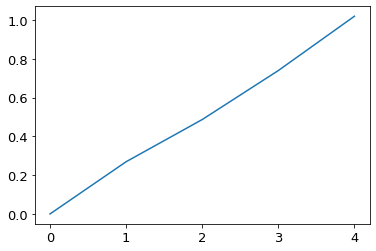

In [100]:
print(np.sum(np.isnan(energy_input_SD_5min)),np.sum(np.isnan(energy_input_SD_5min_tot)),energy_input_SD_5min_tot.shape)
print(np.where(np.isnan(energy_input_SD_5min) == True)[0] )
print(energy_input_SD_5min[0:5])

plt.plot(energy_input_SD_5min)

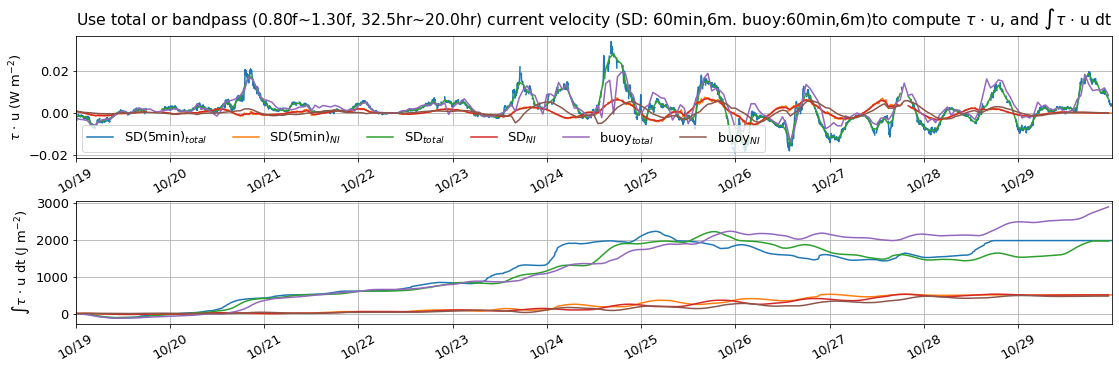

In [113]:
### plot wind power (tau dot NI current velocity in W m^-2) and energy input (integrate wind power over time in J m^-2)
col_in1 = [['royalblue','blue'],['lightcoral','red'],['teal','green']]
nrow = 2
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
### wind power
plt.subplot(nrow,1,1)
plt.plot( dtime_5min_grid, tau_dot_sfcvel_SD_5min_tot, label='SD(5min)$_{total}$')
plt.plot( dtime_5min_grid, tau_dot_sfcvel_SD_5min, label='SD(5min)$_{NI}$')
plt.plot( dtime_hr_grid, tau_dot_sfcvel_SD_tot, label='SD$_{total}$')
plt.plot( dtime_hr_grid, tau_dot_sfcvel_SD, label='SD$_{NI}$')
plt.plot( dtime_hr_grid, tau_dot_sfcvel_buoy_tot, label='buoy$_{total}$')
plt.plot( dtime_hr_grid, tau_dot_sfcvel_buoy, label='buoy$_{NI}$')
plt.legend(ncol=6, loc='lower left')
plt.ylabel('$\u03C4$ $\cdot$ u (W m$^{-2}$)')
### energy input
plt.subplot(nrow,1,2)
plt.plot( dtime_5min_grid, energy_input_SD_5min_tot, label='SD(5min)$_{total}$')
plt.plot( dtime_5min_grid, energy_input_SD_5min, label='SD(5min)$_{NI}$')
plt.plot( dtime_hr_grid, energy_input_SD_tot, label='SD$_{total}$')
plt.plot( dtime_hr_grid, energy_input_SD, label='SD$_{NI}$')
plt.plot( dtime_hr_grid, energy_input_buoy_tot, label='buoy$_{total}$')
plt.plot( dtime_hr_grid, energy_input_buoy, label='buoy$_{NI}$')
# plt.legend(ncol=6, loc='best')
plt.ylabel('$\int$$\u03C4$ $\cdot$ u dt (J m$^{-2}$)')
### figure setting
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()
    # if i == 1:
    #     plt.ylim([0,1500])

plt.suptitle('Use total or bandpass ({:.2f}f~{:.2f}f, {:.1f}hr~{:.1f}hr) current velocity (SD: {:.0f}min,{:.0f}m. buoy:{:.0f}min,{:.0f}m)'.\
             format(n_f[0],n_f[1],bp_sec[0]/3600,bp_sec[1]/3600,dsec_hr/60,depths_cur_SD[iz_SD],dsec_hr/60,depths_cur_buoy[iz_buoy])+\
                'to compute $\u03C4$ $\cdot$ u, and $\int$$\u03C4$ $\cdot$ u dt')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
### save figure
plt.savefig('timeseries_wind-power_energy-input_total-vs-bp({:.2f}f~{:.2f}f)_'.format(n_f[0],n_f[1])+\
            platf_num+'({:.1f}m-QC)'.format(depths_cur_SD[iz_SD])+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(depths_cur_buoy[iz_buoy])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_mn-hr-5min-grid.png',dpi=400,bbox_inches='tight')

In [ ]:
### write data to text/ csv file
# header = 'datetime, uwnd(m/s), vwnd(m/s), taux_c(N/m^2), tauy_c(N/m^2), ucur({:.0f}m)(cm/s), vcur({:.0f}m)(cm/s), tau dot cur(W/m^2), energy input(J/m^2)'\
#     .format(depths_cur_SD[iz_SD],depths_cur_SD[iz_SD])+'. Note: NI band is {:.2f}~{:.2f}f at {:.3f}N'.format(n_f[0],n_f[1],lat_buoy)
# for p in range( len(platforms) ):
#     if p == 0: ### output SD's result only. buoy's result is the same as from compute_wind_power_input.ipynb
#         arr_out = np.column_stack( (dtime_hr_grid, uwnd_SD_grid, vwnd_SD_grid, taux_c_SD_grid, tauy_c_SD_grid, \
#                                     ucur_SD_grid[:,iz_SD], vcur_SD_grid[:,iz_SD], tau_dot_sfcvel_SD, energy_input_SD) )
#     # elif p == 1:
#     #     arr_out = np.column_stack( (dtime_hr_grid, uwnd_buoy_grid, vwnd_buoy_grid, taux_c_buoy_grid, tauy_c_buoy_grid, \
#     #                                 ucur_buoy_grid[:,iz_buoy], vcur_buoy_grid[:,iz_buoy], tau_dot_sfcvel_buoy, energy_input_buoy) )
#         ### write to a file
#         # fileID = open('timeseries_'+platforms[p]+'_wind-power-input_on-buoy-cur-grid_'+tlim_plot[0].strftime('%Y%m%d%HZ-')+tlim_plot[1].strftime('%m%d%HZ')+'.txt','w')
#         fileID = open('timeseries_'+platforms[p]+'(QC)_wind-power-input_on-buoy-cur-grid_bp({:.2f}f~{:.2f}f)_'.format(n_f[0],n_f[1])\
#                       +tlim_plot[0].strftime('%Y%m%d%HZ-')+tlim_plot[1].strftime('%m%d%HZ')+'.txt','w')
#         np.savetxt(fileID,arr_out,fmt='%s',header=header)
#         fileID.close()

In [114]:
print('=== results by bandpass {:.0f}m current velocity at {:.2f}f~{:.2f}f band: ==='.format(depths_cur_SD[iz_SD],n_f[0],n_f[1]))
# tlim_check = [datetime.datetime(int(year),10,30),datetime.datetime(int(year),10,31)]
tlim_check = [datetime.datetime(int(year),10,29),datetime.datetime(int(year),10,30)]
it = np.where( (dtime_hr_grid>= tlim_check[0]) & (dtime_hr_grid<= tlim_check[1]) )[0]
res = []
for i in range( len(platforms) ):
    mn = np.mean( eval('energy_input_'+platforms[i]+'[it]') )
    res.append(mn)
    print(platforms[i],' mean energy input btw',tlim_check,'= {:.2f} (J/m^2)'.format(mn))
print(platforms[0]+'/'+platforms[1],res[0]/res[1])

=== results by bandpass 6m current velocity at 0.80f~1.30f band: ===
SD  mean energy input btw [datetime.datetime(2023, 10, 29, 0, 0), datetime.datetime(2023, 10, 30, 0, 0)] = 506.88 (J/m^2)
buoy  mean energy input btw [datetime.datetime(2023, 10, 29, 0, 0), datetime.datetime(2023, 10, 30, 0, 0)] = 460.88 (J/m^2)
SD/buoy 1.0998008048985854
